In [1]:
# Load Dependencies
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras.backend as K

from helpers.image import get_image, save_image
from helpers.image import generate_noise_image, generate_noise_image2
from helpers.model import compute_content_cost, compute_style_cost, total_cost
from helpers.model import get_model, nst_model

from config import CONFIG

Using TensorFlow backend.


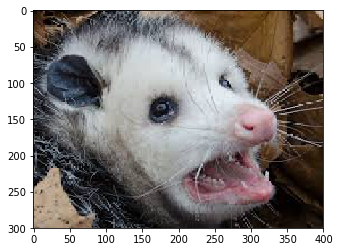

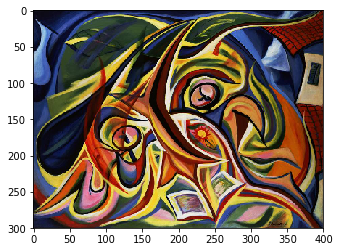

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


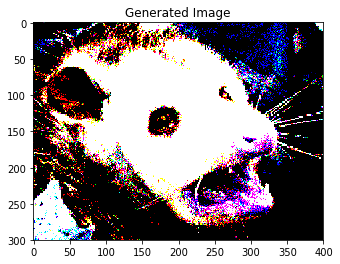

In [5]:
# Get Images
content_path = '../data/oppossum.jpeg'
style_path = '../data/cubism-1.jpg'

content_img = get_image(content_path, show=True)
style_img = get_image(style_path, show=True)
# generated_img = generate_noise_image(content_path, show=True)
generated_img = generate_noise_image2(content_img[0], show=True)


In [3]:
# Change get_model and Cost Functions
from keras.models import Model
from keras.applications.vgg19 import VGG19

def get_model():
    vgg = VGG19(include_top=False, 
                weights='imagenet', 
                input_shape=(CONFIG.HEIGHT, CONFIG.WIDTH, CONFIG.NUM_CHANNELS))
    vgg.trainable = False
    
    input_layers = [vgg.get_layer('input_1').output]
    content_layers = [vgg.get_layer(layer_name).output for layer_name in CONFIG.CONTENT_LAYERS]
    style_layers = [vgg.get_layer(layer_name).output for layer_name,coeff in CONFIG.STYLE_LAYERS]

    outputs = input_layers + content_layers + style_layers
    
    return Model(vgg.input, outputs)

In [4]:
def compute_gradient(loss, input_activations):
    """ Compute gradients using the input layer """
    return K.gradients(loss, input_activations)

In [31]:
def nst_model(sess, model, input_img, content_img, style_img, 
              num_iterations = 200, learning_rate = 0.01):
    a_C = model(content_img)[1]
    a_S = model(style_img)[2:]
    a_G = model(input_img)
    
    # Costs
    J_content = compute_content_cost(a_C, a_G[1])
    J_style = compute_style_cost(a_S, a_G[2:])
    J = total_cost(J_content, J_style)
    
    # Optimizer
    grads = compute_gradient(J, a_G[0])
    optimizer = tf.train.AdamOptimizer(1.5)
    train_step = optimizer.apply_gradients([(grads, input_img)])
    
    # Time iterations
    start_fn = time.time()
    
    sess.run(tf.global_variables_initializer())
    
    for i in range(num_iterations):
        sess.run(train_step)
        
        # Print every 10 iterations
        if i % 10 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print('Total Cost:  ', Jt)
            print('\tContent Cost:', Jc)
            print('\tStyle Cost:  ', Js)
            save_image('../images/test/{}.jpg'.format(i), sess.run(input_img)[0])
            end_fn = time.time()
            print('Total time:  ', end_fn - start_fn)
            start_fn = time.time()
        print('Finished Iteration: {}'.format(i))
            
    save_image('../images/test/final.jpg', sess.run(input_img)[0])
    print('Saved final image!')

In [32]:
tf.reset_default_graph()

with tf.Session() as sess:
    content_img = get_image(content_path, show=False)
    style_img = get_image(style_path, show=False)
    # generated_img = generate_noise_image(content_path, show=False)
    generated_img = generate_noise_image2(content_img[0], show=False)
    
    # Turn images into Tensorflow Constants / Variables
    content_img = K.constant(content_img, name='content_img', dtype='float32')
    style_img = K.constant(style_img, name='style_img', dtype='float32')
    generated_img = K.variable(generated_img, name='generated_img', dtype='float32')

    model = get_model()
    nst_model(sess, model, generated_img, content_img, style_img)

TypeError: Gradient must be convertible to a Tensor or IndexedSlices, or None: [None]